## Studying Titanic Kernels
---
### Contents
1. Load & Check Data
2. Feature Analysis
3. Fill Missing Values
4. Feature Engineering
5. Modeling

## 1. Load & Check Data

In [0]:
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
testID = test.PassengerId

### Detecting Outliers (Tukey's Method)

In [2]:
import numpy as np
from collections import Counter

def detect_outliers(df, n, features):
  outlier_indices = []
  for feature in features:
    Q1 = np.percentile(df[feature], 25)
    Q3 = np.percentile(df[feature], 75)
    IQR = Q3-Q1
    outlier_step = 1.5*IQR
    outlier_index = df[(df[feature]<Q1-outlier_step)|(df[feature]>Q3+outlier_step)].index
    outlier_indices.extend(outlier_index)
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = [k for k, v in outlier_indices.items() if v > n]
  return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [3]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [0]:
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

### Joining the Two Datasets

In [0]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0, sort=True).reset_index(drop=True)

### Checking Missing Values

In [6]:
dataset.fillna(np.nan, inplace=True)
print('Train : {}'.format(train.shape))
print('Test : {}'.format(test.shape))
dataset.isnull().sum()

Train : (881, 12)
Test : (418, 11)


Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


## 2. Feature Analysis

### 1. Numerical Values

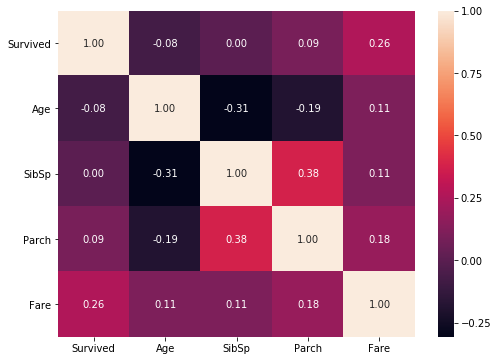

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, fmt='.2f')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

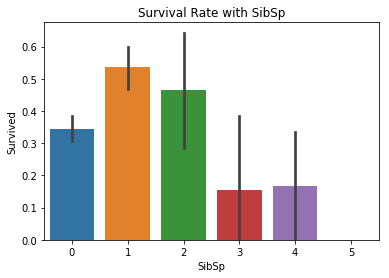

In [9]:
sns.barplot('SibSp', 'Survived', data=train).set_title('Survival Rate with SibSp')
plt.show()

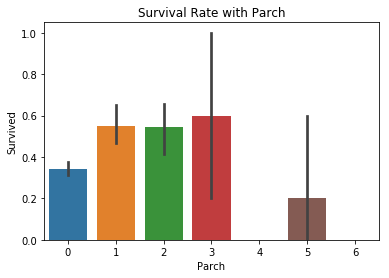

In [10]:
sns.barplot('Parch', 'Survived', data=train).set_title('Survival Rate with Parch')
plt.show()

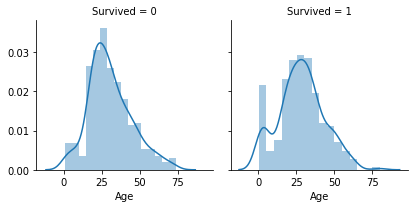

In [11]:
g = sns.FacetGrid(train, col='Survived')
g.map(sns.distplot, 'Age')
plt.show()

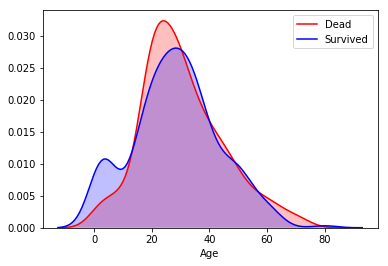

In [12]:
g = sns.kdeplot(train.loc[(train.Survived==0)&(train.Age.notnull()), 'Age'], color='Red', shade=True)
g = sns.kdeplot(train.loc[(train.Survived==1)&(train.Age.notnull()), 'Age'], color='Blue', shade=True)
g.set_xlabel('Age')
g.legend(['Dead', 'Survived'])
plt.show()

In [0]:
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

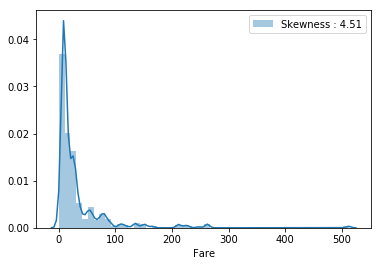

In [14]:
g = sns.distplot(dataset.Fare, label='Skewness : {:.2f}'.format(dataset.Fare.skew()))
g.legend(loc='best')
plt.show()

In [0]:
dataset.Fare = dataset.Fare.map(lambda i: np.log(i) if i>0 else 0)

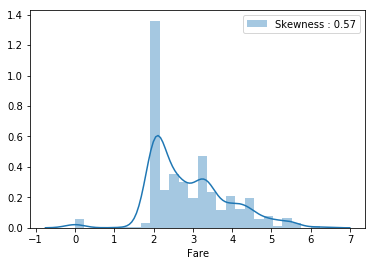

In [16]:
g = sns.distplot(dataset.Fare, label='Skewness : {:.2f}'.format(dataset.Fare.skew()))
g.legend(loc='best')
plt.show()

### 2. Categorical Values

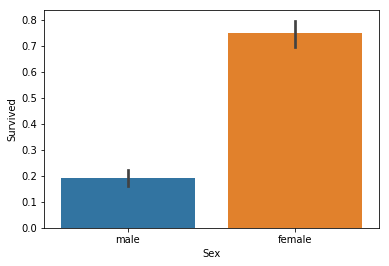

In [17]:
sns.barplot('Sex', 'Survived', data=train)
plt.show()

In [18]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


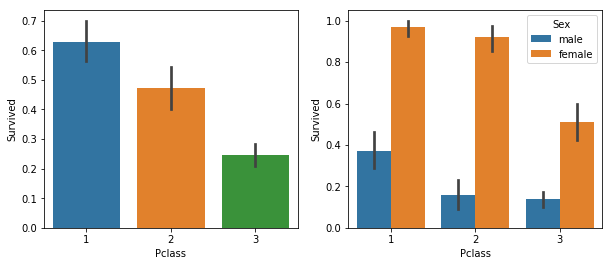

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot('Pclass', 'Survived', data=train, ax=ax[0])
sns.barplot('Pclass', 'Survived', hue='Sex', data=train, ax=ax[1])

plt.show()

In [20]:
dataset.Embarked.value_counts().idxmax()

'S'

In [0]:
dataset.Embarked.fillna('S', inplace=True)

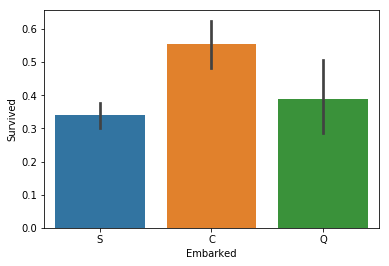

In [22]:
sns.barplot('Embarked', 'Survived', data=train)
plt.show()

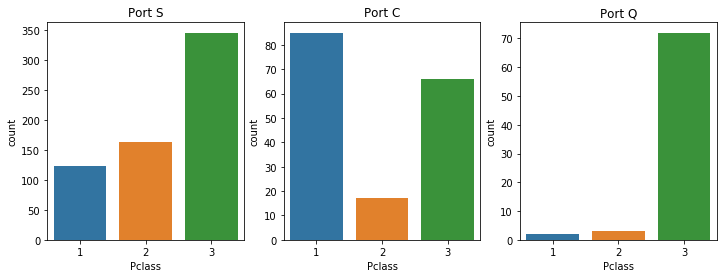

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.countplot('Pclass', data=train.loc[train.Embarked=='S'], ax=ax[0]).set_title('Port S')
sns.countplot('Pclass', data=train.loc[train.Embarked=='C'], ax=ax[1]).set_title('Port C')
sns.countplot('Pclass', data=train.loc[train.Embarked=='Q'], ax=ax[2]).set_title('Port Q')

plt.show()

## 3. Filling Missing Values

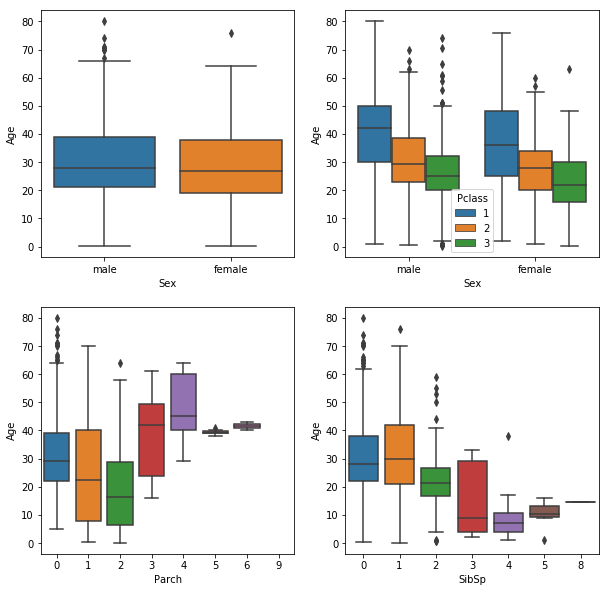

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot('Sex', 'Age', data=dataset, ax=ax[0, 0])
sns.boxplot('Sex', 'Age', hue='Pclass', data=dataset, ax=ax[0, 1])
sns.boxplot('Parch', 'Age', data=dataset, ax=ax[1, 0])
sns.boxplot('SibSp', 'Age', data=dataset, ax=ax[1, 1])

plt.show()

In [0]:
dataset.Sex.replace(['male', 'female'], [0, 1], inplace=True)

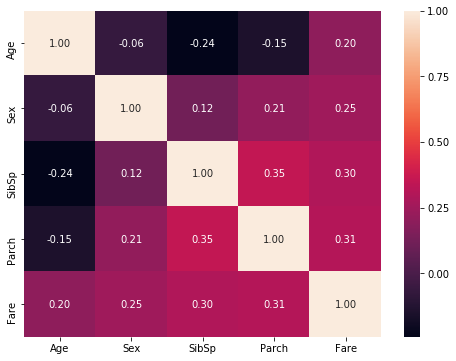

In [26]:
sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, fmt='.2f')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

In [27]:
nan_age_index = list(dataset.loc[dataset.Age.isnull(), 'Age'].index)
age_med = dataset.Age.median()

for idx in nan_age_index:
  pred = dataset.loc[(dataset.SibSp==dataset.iloc[idx]['SibSp'])&(dataset.Parch==dataset.iloc[idx]['Parch'])&(dataset.Pclass==dataset.iloc[idx]['Pclass']), 'Age'].mean()
  if np.isnan(pred):
    dataset.Age.iloc[idx] = age_med
  else:
    dataset.Age.iloc[idx] = pred

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


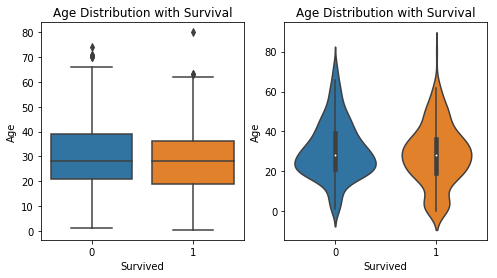

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot('Survived', 'Age', data=train, ax=ax[0]).set_title('Age Distribution with Survival')
sns.violinplot('Survived', 'Age', data=train, ax=ax[1]).set_title('Age Distribution with Survival')

plt.show()

## 4. Feature Engineering

### 1. Name

In [29]:
dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.')
dataset.Title.head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

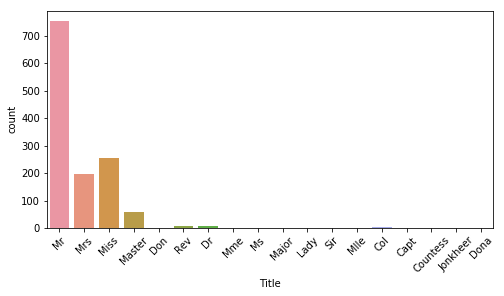

In [30]:
g = sns.countplot('Title', data=dataset)
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [31]:
pd.crosstab(dataset.Title, dataset.Sex).T

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
0,1,4,0,1,0,7,1,0,2,60,0,0,0,753,0,0,8,1
1,0,0,1,0,1,1,0,1,0,0,255,2,1,0,197,2,0,0


In [0]:
dataset.Title.replace(
  ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
  'Rare', inplace=True
)
dataset.Title = dataset.Title.map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset.Title = dataset.Title.astype(int)

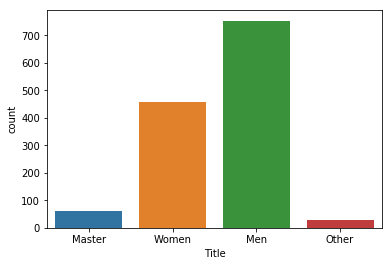

In [33]:
g = sns.countplot(dataset.Title)
g = g.set_xticklabels(['Master', 'Women', 'Men', 'Other'])
plt.show()

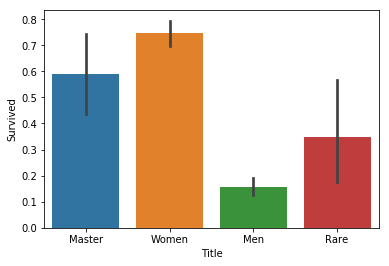

In [34]:
sns.barplot('Title', 'Survived', data=dataset).set_xticklabels(['Master', 'Women', 'Men', 'Rare'])
plt.show()

In [0]:
dataset.drop('Name', axis=1, inplace=True)

### 2. Family Size

In [0]:
dataset['Fsize'] = dataset['Parch'] + dataset['SibSp'] + 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


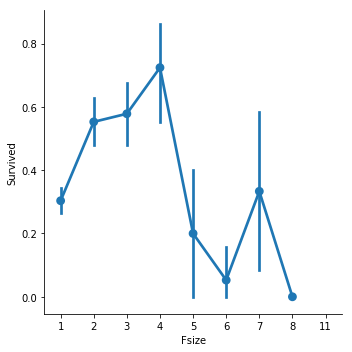

In [37]:
sns.factorplot('Fsize', 'Survived', data=dataset)
plt.show()

In [0]:
dataset['Single'], dataset['SmallF'], dataset['MedF'], dataset['LargeF'] = 0, 0, 0, 0

dataset.loc[dataset.Fsize==1, 'Single']=1
dataset.loc[dataset.Fsize==2, 'SmallF']=1
dataset.loc[(dataset.Fsize>=3)&(dataset.Fsize<=4), 'MedF']=1
dataset.loc[dataset.Fsize>=5, 'LargeF']=1

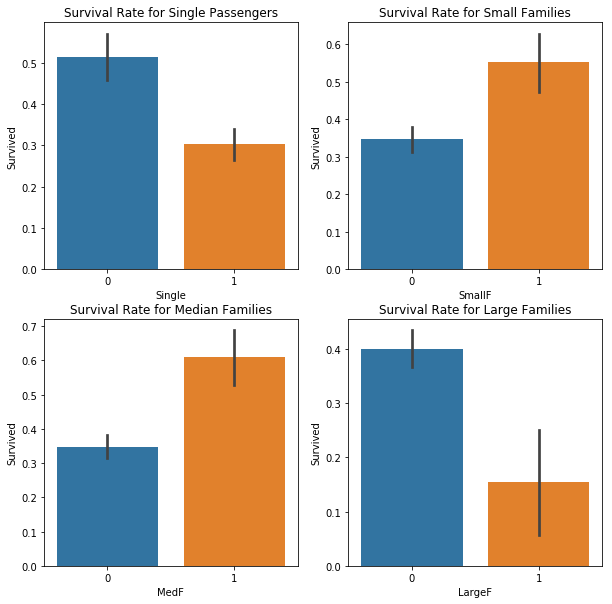

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot('Single', 'Survived', data=dataset, ax=ax[0, 0])
ax[0, 0].set_title('Survival Rate for Single Passengers')

sns.barplot('SmallF', 'Survived', data=dataset, ax=ax[0, 1])
ax[0, 1].set_title('Survival Rate for Small Families')

sns.barplot('MedF', 'Survived', data=dataset, ax=ax[1, 0])
ax[1, 0].set_title('Survival Rate for Median Families')

sns.barplot('LargeF', 'Survived', data=dataset, ax=ax[1, 1])
ax[1, 1].set_title('Survival Rate for Large Families')

plt.show()

In [0]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [41]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,2,0,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,2,0,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,2,0,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,1,1,0,0,0,0,0,1,0,0,0,1


### 3. Cabin

In [42]:
dataset.Cabin.describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [43]:
dataset.Cabin.isnull().sum()

1007

In [44]:
dataset.loc[dataset.Cabin.notnull(), 'Cabin'].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [0]:
dataset.Cabin = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset.Cabin)

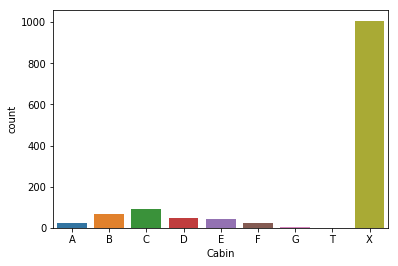

In [46]:
order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X']
sns.countplot('Cabin', data=dataset, order=order)
plt.show()

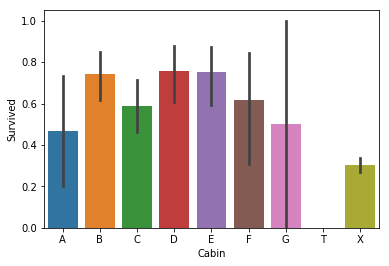

In [47]:
sns.barplot('Cabin', 'Survived', data=dataset, order=order)
plt.show()

In [0]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='cab')

In [49]:
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,cab_A,cab_B,cab_C,cab_D,cab_E,cab_F,cab_G,cab_T,cab_X
0,22.0,1.981001,0,1,3,0,1,0.0,A/5 21171,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,PC 17599,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,113803,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,373450,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


### 4. Ticket

In [50]:
dataset.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [51]:
Ticket = []
for t in list(dataset.Ticket):
  if t.isdigit():
    Ticket.append('X')
  else:
    Ticket.append(t.replace('/', '').replace('.', '').strip().split(' ')[0])
    
dataset['Ticket'] = Ticket
dataset.Ticket.head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [0]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [0]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='pc')

In [0]:
dataset.drop('PassengerId', axis=1, inplace=True)

In [55]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,cab_A,cab_B,cab_C,cab_D,cab_E,cab_F,cab_G,cab_T,cab_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,pc_1,pc_2,pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## 5. Modeling

In [56]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop('Survived', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [57]:
train.Survived = train.Survived.astype(int)
train_y = train.Survived
train_X = train.drop('Survived', axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [0]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10)

In [0]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
classifiers = [
    SVC(random_state=0),
    DecisionTreeClassifier(random_state=0),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=0), random_state=0, learning_rate=0.1),
    RandomForestClassifier(random_state=0),
    ExtraTreesClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    MLPClassifier(random_state=0),
    KNeighborsClassifier(),
    LogisticRegression(random_state=0),
    LinearDiscriminantAnalysis()
]

In [0]:
from sklearn.model_selection import cross_val_score

cv_result, cv_mean, cv_std = [], [], []
for clf in classifiers:
  cv_result.append(cross_val_score(clf, train_X, train_y, scoring='accuracy', cv=kfold, n_jobs=2))

for res in cv_result:
  cv_mean.append(res.mean())
  cv_std.append(res.std())

df = pd.DataFrame({'CV mean':cv_mean, 'CV std':cv_std, 'Model':['SVC', 'DTC', 'ABC', 'RFC', 'ETC', 'GBC', 'MLP', 'KNN', 'LR', 'LDA']})

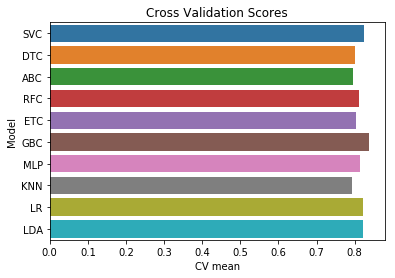

In [62]:
sns.barplot('CV mean', 'Model', data=df, orient='h').set_title('Cross Validation Scores')
plt.show()

### Hyperparameter Tuning

In [66]:
from sklearn.model_selection import GridSearchCV

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(DTC, random_state=0)
hyper = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'algorithm' : ['SAMME', 'SAMME.R'],
    'n_estimators' : [10, 30, 50, 70, 90],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3]
}

gd = GridSearchCV(ABC, param_grid=hyper, cv=kfold, scoring='accuracy', n_jobs=2, verbose=True)
gd.fit(train_X, train_y)

print('Best Score : {}'.format(gd.best_score_))
abc_best = gd.best_estimator_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   36.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:  5.9min finished


Best Score : 0.8308740068104427


In [67]:
ETC = ExtraTreesClassifier(random_state=0)
hyper = {
    'max_depth' : [None],
    'max_features' : [1, 3, 10],
    'min_samples_split' : [2, 3, 10],
    'min_samples_leaf' : [1, 3, 10],
    'bootstrap' : [False],
    'n_estimators' : [100, 200, 300],
    'criterion' : ['gini']
}

gd = GridSearchCV(ETC, param_grid=hyper, cv=kfold, scoring='accuracy', n_jobs=2, verbose=True)
gd.fit(train_X, train_y)

print('Best Score : {}'.format(gd.best_score_))
etc_best = gd.best_estimator_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   37.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.6min


Best Score : 0.8297389330306469


[Parallel(n_jobs=2)]: Done 810 out of 810 | elapsed:  2.7min finished


In [68]:
RFC = RandomForestClassifier(random_state=0)
hyper = {
    'max_depth' : [None],
    'max_features' : [1, 3, 10],
    'min_samples_split' : [2, 3, 10],
    'min_samples_leaf' : [1, 3, 10],
    'bootstrap' : [False],
    'n_estimators' : [100, 200, 300],
    'criterion' : ['gini']
}

gd = GridSearchCV(RFC, param_grid=hyper, cv=kfold, scoring='accuracy', n_jobs=2, verbose=True)
gd.fit(train_X, train_y)

print('Best Score : {}'.format(gd.best_score_))
rfc_best = gd.best_estimator_

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   41.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  2.9min


Best Score : 0.8320090805902384


[Parallel(n_jobs=2)]: Done 810 out of 810 | elapsed:  2.9min finished


In [69]:
GBC = GradientBoostingClassifier(random_state=0)
hyper = {
    'loss' : ['deviance'],
    'n_estimators' : [100, 200, 300],
    'learning_rate' : [0.01, 0.1, 0.5],
    'max_depth' : [2, 3, 4],
    'min_samples_leaf' : [1, 2, 3],
    'max_features' : [0.2, 0.3, 0.4]
}

gd = GridSearchCV(GBC, param_grid=hyper, cv=kfold, scoring='accuracy', n_jobs=2, verbose=True)
gd.fit(train_X, train_y)

print('Best Score : {}'.format(gd.best_score_))
gbc_best = gd.best_estimator_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   54.3s
[Parallel(n_jobs=2)]: Done 730 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 1080 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 1530 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done 2080 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 2430 out of 2430 | elapsed:  7.2min finished


Best Score : 0.8388195232690124


In [70]:
SVMC = SVC(probability=True, random_state=0)
hyper = {
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1],
    'C' : [1, 5, 10, 50, 100, 200, 300]
}

gd = GridSearchCV(SVMC, param_grid=hyper, cv=kfold, scoring='accuracy', n_jobs=2, verbose=True)
gd.fit(train_X, train_y)

print('Best Score : {}'.format(gd.best_score_))
svc_best = gd.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   47.1s
[Parallel(n_jobs=2)]: Done 280 out of 280 | elapsed:  1.2min finished


Best Score : 0.8354143019296254


### Plotting Learning Curves

In [0]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training Examples')
  plt.ylabel('Score')
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean= np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()
  
  plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='CV Score')
  plt.legend(loc='best')
  plt.show()

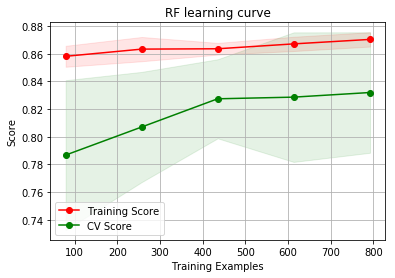

In [72]:
plot_learning_curve(rfc_best, 'RF learning curve', train_X, train_y, cv=kfold)

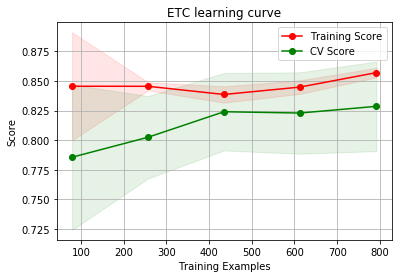

In [73]:
plot_learning_curve(etc_best, 'ETC learning curve', train_X, train_y, cv=kfold)

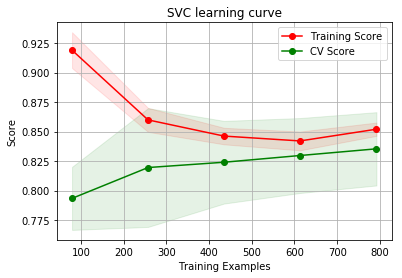

In [74]:
plot_learning_curve(svc_best, 'SVC learning curve', train_X, train_y, cv=kfold)

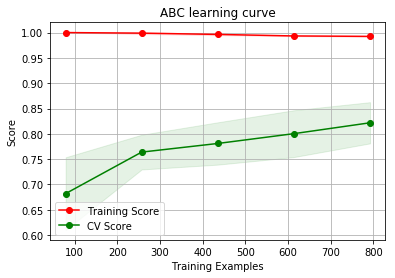

In [75]:
plot_learning_curve(abc_best, 'ABC learning curve', train_X, train_y, cv=kfold)

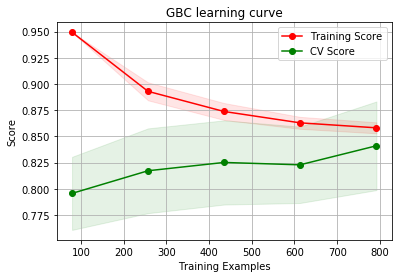

In [76]:
plot_learning_curve(gbc_best, 'GBC learning curve', train_X, train_y, cv=kfold)

### Feature Importances

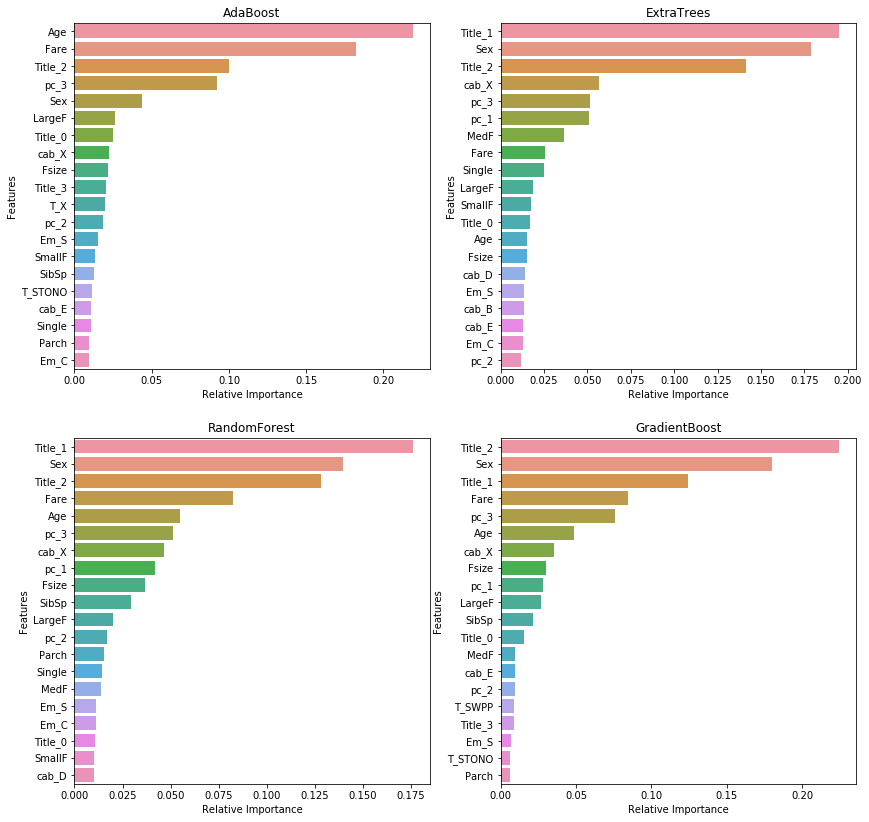

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
nc = [('AdaBoost', abc_best), ('ExtraTrees', etc_best), ('RandomForest', rfc_best), ('GradientBoost', gbc_best)]

clf_idx = 0
for r in range(2):
  for c in range(2):
    name, clf = nc[clf_idx]
    indices = np.argsort(clf.feature_importances_)[::-1][:20]
    g = sns.barplot(y=train_X.columns[indices], x=clf.feature_importances_[indices], orient='h', ax=ax[r][c])
    g.set_xlabel('Relative Importance')
    g.set_ylabel('Features')
    g.set_title(name)
    clf_idx += 1

In [0]:
test_survived_rfc = pd.Series(rfc_best.predict(test), name='RFC')
test_survived_etc = pd.Series(etc_best.predict(test), name='ETC')
test_survived_svc = pd.Series(svc_best.predict(test), name='SVC')
test_survived_abc = pd.Series(abc_best.predict(test), name='ABC')
test_survived_gbc = pd.Series(gbc_best.predict(test), name='GBC')

In [0]:
preds = pd.concat([test_survived_rfc, test_survived_etc, test_survived_svc, test_survived_abc, test_survived_gbc], axis=1)

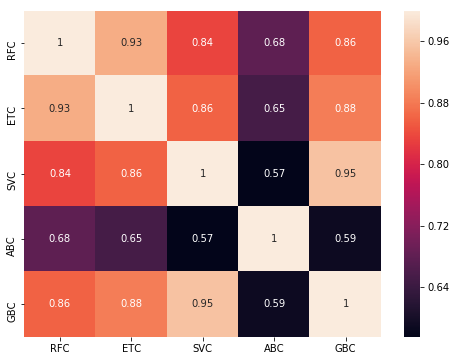

In [80]:
sns.heatmap(preds.corr(), annot=True)
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

In [81]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(
  estimators = [
      ('rfc', rfc_best),
      ('etc', etc_best),
      ('svc', svc_best),
      ('abc', abc_best),
      ('gbc', gbc_best)
  ],
  voting='soft',
  n_jobs=2
)

model.fit(train_X, train_y)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=3,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=200,
                                                     n_jobs=None,
             

### Prediction

In [0]:
test_survived = pd.Series(model.predict(test), name='Survived')
result = pd.concat([testID, test_survived], axis=1)

In [83]:
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [0]:
result.to_csv('./submission.csv', index=False)